# ROICaT Classification Colab Notebook

Welcome to the interactive ROI classification notebook! This Colab notebook allows you to easily classify ROIs in your calcium imaging data, using a stable version of [ROICaT](https://github.com/RichieHakim/ROICaT). 


This Colab notebook is designed to work with  **Suite2p output file** (stat.npy and ops.npy).


**Before we start**

We **STRONGLY** recommend running this Colab notebook with GPU. Please check your runtime setting:

_Runtime -> Change runtime type -> Hardware accelerator -> choose GPU_


**More information**

FAQ on how to play with ROICaT is [here](https://roicat.readthedocs.io/en/dev/).

If you have any questions not covered in the FAQ, please don't hesitate to open a new issue tap on [ROICaT github page](https://github.com/RichieHakim/ROICaT/issues).

**The notebook proceeds as follows:**
1. **Import** libraries
2. Define **paths** to data
3. Run data through the **pipeline**.
4. Draw to select **good ROIs**
5. **Visualize** results
6. **Save** results

As you go through the notebook, we will explicitly ask you to choose the small number of parameters that are **'important parameters'**. We consider these to be the only parameters that can have a large effect on the run output. Other parameters matter and should be considered as well, but are less critical.

# SETUP

In [ ]:
#@title Install ROICaT
#@markdown Please execute this cell by pressing the _Play_ button on the left. This process will take less than 5 min.

#@markdown Please note that this cell installs ROICaT on the Colab **TEMPORARY** directory in the cloud, not on your local machine or google drive.

#@markdown After running this cell, kernal **automatically RESTARTS**.

# # Clone ROICaT repository
GIT_REPO = 'https://github.com/RichieHakim/ROICaT.git'

!git clone {GIT_REPO}
# !git clone -b dev --single-branch {GIT_REPO}

# Install ROICaT
import os
os.chdir('/content/ROICaT')
!pip uninstall -y tensorflow # Uninstall default tensorflow to avoid any potential conflict
!pip install --user -v -e .[classification]

display("Runtime automatically restarts...")
os._exit(0)

Cloning into 'ROICaT'...
remote: Enumerating objects: 3200, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 3200 (delta 273), reused 452 (delta 269), pack-reused 2642
Receiving objects: 100% (3200/3200), 307.84 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (1995/1995), done.
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ROICaT
  Running command python setup.py egg_info
  {'deps_all': ['einops==0.6.1', 'hdbscan==0.8.29', 'holoviews[recommended]==1.16.2', 'jupyter==1.0.0', 'kymatio==0.3.0', 'matplotlib==3.7.1', 'natsort==8.3.1', 'numpy==1.24.3', 'opencv_contrib_python==4.7.0.72', 'optuna==3.2.0', 'paramiko==3.2.0', 'Pillow==9.5.0', 'pytes

In [ ]:
#@title Load modules

# Load basic modules
import os
import zipfile
from pathlib import Path
import copy
from functools import partial
from datetime import datetime
from tqdm import tqdm

import random
import numpy as np
import sklearn
from umap import UMAP

import torch
import torchvision

# Load plotting modules
import io
import base64
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import widgets, Button, Output
from IPython.display import display

/root/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword 

In [ ]:
#@title Helper Functions
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU instead")
    return device

def dataloader_params_wrapper(colab_device):
  dataloader_params = {}
  if colab_device == torch.device('cuda'):
    print("Using GPU")
    dataloader_params['batchSize_dataloader'] = 8
    dataloader_params['pinMemory_dataloader'] = True
    dataloader_params['numWorkers_dataloader'] = -1
    dataloader_params['persistentWorkers_dataloader'] = True
    dataloader_params['prefetchFactor_dataloader'] = 2
  elif colab_device == torch.device('cpu'):
    print("Using CPU")
    dataloader_params['batchSize_dataloader'] = 1
    dataloader_params['pinMemory_dataloader'] = False
    dataloader_params['numWorkers_dataloader'] = 0
    dataloader_params['persistentWorkers_dataloader'] = False
    dataloader_params['prefetchFactor_dataloader'] = None
  else:
    print("Unknown environment. Please double-check your runtime setting.")
  return dataloader_params

In [ ]:
#@title Plotting Functions

## crappy heuristic for spreading out points
def get_spread_out_points(embeddings, thresh_dist=0.3, n_iter=3):

    def make_dist_mat(embeddings):
        dist_mat = sklearn.neighbors.NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None).fit(embeddings).kneighbors_graph(embeddings, n_neighbors=300, mode='distance').toarray()
        dist_mat[dist_mat==0.0] = np.nan
        return dist_mat

    def prune(dist_mat_pruned, thresh_dist, bool_good):
        idx_rand = np.random.permutation(np.arange(dist_mat_pruned.shape[0]))

        for idx in tqdm(idx_rand):
            if np.nanmin(dist_mat_pruned[idx]) < thresh_dist:

                dist_mat_pruned[idx] = np.nan
                dist_mat_pruned[:,idx] = np.nan

                bool_good[idx] = False
        return dist_mat_pruned, bool_good

    def grow(dist_mat_pruned, dist_mat_raw, thresh_dist, bool_good):
        idx_good = np.nonzero(bool_good)[0]
        idx_bad = np.nonzero(~bool_good)[0]
        for idx in idx_bad:
            if np.nanmin(dist_mat_raw[idx][idx_good]) > thresh_dist:
                dist_mat_pruned[idx] = dist_mat_raw[idx]
                dist_mat_pruned[:,idx] = dist_mat_raw[:,idx]
                bool_good[idx] = True
        return dist_mat_pruned, bool_good

    dist_mat_raw = make_dist_mat(embeddings)

    n_sf = embeddings.shape[0]

    bool_good = np.ones(n_sf, dtype=np.bool_)
    
    dist_mat_pruned = copy.deepcopy(dist_mat_raw)
    
    for ii in range(n_iter):
        dist_mat_pruned, bool_good = prune(dist_mat_pruned, thresh_dist, bool_good)
        dist_mat_pruned, bool_good = grow(dist_mat_pruned, dist_mat_raw, thresh_dist, bool_good)
    dist_mat_pruned, bool_good = prune(dist_mat_pruned, thresh_dist, bool_good)

    return bool_good, dist_mat_pruned

In [ ]:
#@title Interactive Widget Functions

# Checkbox widget
def checkbox_widget(input_list):
  checkboxes = []
  for input in input_list:
    checkbox = widgets.Checkbox(description=input, value=False)
    checkboxes.append(checkbox)

  selected_indices = []
  return checkboxes, selected_indices

def get_selected_indices(checkboxes):
  indices = [i for i, checkbox in enumerate(checkboxes) if checkbox.value]
  return indices

def make_checkbox_button_clicked(checkboxes, selected_indices):
  def checkbox_button_clicked(_):
    # _ is a placeholder argument to handle button click event
    # Clear the list
    selected_indices.clear()
    # Add the newly selected indices
    selected_indices.extend(get_selected_indices(checkboxes))
  return checkbox_button_clicked

In [ ]:
#@title Load ROICaT
import sys
sys.path.append('/content/ROICaT')

import roicat

colab_device = set_device()

GPU is available


# Import paths

### Mount google drive (OPTION 1: RECOMMENDED)

In [ ]:
#@markdown You can upload your data onto Google Drive and mount the drive to access.

#@markdown This process allows you access to your data directory on Google Drive.

from google.colab import drive
path_gdrive = '/content/gdrive'
drive.mount(path_gdrive, force_remount=True)

Mounted at /content/gdrive


In [ ]:
#@markdown ### Enter your suite2p files directory:
dir_s2p = '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/' #@param {type:"string"}

### Upload file from local (OPTION 2)


In [ ]:
#@markdown This cell allows you to load files (**not directories**) from local. Please note that loading file from local to Colab cloud is pretty slow. Also, you should **LOAD FILE AGAIN** if runtime terminates.

#@markdown a) For a single session, you can load individual stat.npy and ops.npy file.


#@markdown b) If you have **nested** suite2p output file structures from multiple sessions, create and upload a **zip file**. This cell detects and extracts uploaded zip file.


from google.colab import files
uploaded = files.upload()

for file_name in list(uploaded.keys()):
  file_path = Path.cwd() / file_name
  if file_path.exists():
    if zipfile.is_zipfile(file_path):
      print("Zip file detected: ", file_path)
      with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(Path.cwd())
        print("Zip file extracted to: ", Path.cwd())
    else:
      print("Uploaded file is not a zip file: ", file_path)
  else:
    print("Failed to detect uploaded file path: ", file_path)

dir_s2p = os.getcwd()

Saving ops.npy to ops.npy
Saving stat.npy to stat.npy
Uploaded file is not zip file:  /content/ops.npy
Uploaded file is not zip file:  /content/stat.npy


### Select sessions to classify

In [ ]:
#@markdown **Check and select stat files to classify:**

statFile = 'stat.npy' #@param {type:"string"}
opsFile = 'ops.npy' #@param {type:"string"}
#@markdown Automatically searches for matching file names.
#@markdown
#@markdown **Default: stat.npy, ops.npy**, _type: str_

paths_statFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch=statFile, depth=8)
paths_opsFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch=opsFile, depth=8)
print('paths_statFiles')
display(paths_statFiles)
print('paths_opsFiles')
display(paths_opsFiles)

# Default Stat / Ops files
paths_allStat = paths_statFiles
paths_allOps = paths_opsFiles

stat_list = ['/'.join(Path(statfile).parts[-3:]) for statfile in paths_statFiles]
stat_checkboxes, selected_indices = checkbox_widget(stat_list)
checkbox_display = widgets.VBox(stat_checkboxes)
display(checkbox_display)
button = Button(description="Get Stat Files")
button.on_click(make_checkbox_button_clicked(stat_checkboxes, selected_indices))

display(button)

paths_statFiles


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230419/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230420/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230424/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230425/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230426/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230427/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230428/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230429/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230430/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230501/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/stat.npy',
 '/content/gdrive/MyD

paths_opsFiles


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230419/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230420/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230424/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230425/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230426/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230427/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230428/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230429/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230430/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230501/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/ops.npy',
 '/content/gdrive/MyDrive/Colab_

Button(description='Get Selected Indices', style=ButtonStyle())

In [ ]:
#@markdown Selected sessions to classify:

stat_selected_indices = ops_selected_indices = selected_indices

paths_allStat = [paths_statFiles[i] for i in stat_selected_indices]
print("Stat files")
display(paths_allStat)
paths_allOps = [paths_opsFiles[i] for i in ops_selected_indices]
print("Ops files")
display(paths_allOps)

Stat files


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/stat.npy']

Ops files


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/ops.npy']

In [ ]:
#@markdown Optional: If selected ops files do not correspond with the stat files, you can manually curate the error:
ops_list = ['/'.join(Path(opsfile).parts[-3:]) for opsfile in paths_opsFiles]
ops_checkboxes, ops_selected_indices = checkbox_widget(ops_list)
checkbox_display = widgets.VBox(ops_checkboxes)
display(checkbox_display)
button = Button(description="Get Ops Files")
button.on_click(make_checkbox_button_clicked(ops_checkboxes, ops_selected_indices))

display(button)

Button(description='Get Selected Indices', style=ButtonStyle())

In [ ]:
#@markdown Sessions to classify, finalized:

paths_allStat = [paths_statFiles[i] for i in stat_selected_indices]
print("Stat files")
display(paths_allStat)
paths_allOps = [paths_opsFiles[i] for i in ops_selected_indices]
print("Ops files")
display(paths_allOps)

Stat files


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/stat.npy']

Ops files


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/ops.npy']

# Import Data

In [ ]:
#@markdown ### Enter micrometers per pixel of the imaging FOV (no need to be accurate):
um_per_pixel = 2.5 #@param {type:"number"}
#@markdown **Default: 2.5**, _type: float_

visualize_ROI_size = [int(90/um_per_pixel), int(90/um_per_pixel)]

In [ ]:
#@markdown Load ROIs...

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=um_per_pixel,
    new_or_old_suite2p='new',
    out_height_width=visualize_ROI_size,
    type_meanImg='meanImgE',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

/content/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


# Pass ROI images through ROInet

In [ ]:
#@markdown Initialize the ROInet object.The ROInet_embedder class will automatically download and load a pretrained ROInet model for classification. 
#@markdown
#@markdown If you have a GPU, this step will be much faster.
roinet = roicat.ROInet.ROInet_embedder(
    device=colab_device,
    dir_networkFiles=os.getcwd(),
    download_method='check_local_first',
    download_url='https://osf.io/c8m3b/download',
#     download_hash='3d767bfec446c91dad8e5909c1b697c1',
    forward_pass_version='head',
    verbose=True,
)

dataloader_params = dataloader_params_wrapper(colab_device)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    **dataloader_params,
);

roinet.generate_latents();

/content/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


File does not exist locally: /content/ROInet.zip. Will attempt download from https://osf.io/c8m3b/download


100%|██████████| 100M/100M [00:08<00:00, 12.4MB/s] 


Hash of downloaded file does not match hash_hex.
Hash of downloaded file: 357a8d9b630ec79f3e015d0056a4c2d5
Hash provided in hash_hex: None
Extracting /content/ROInet.zip to /content.
Completed zip extraction.
['/content/ROInet_classification_20220902', '/content/ROInet_classification_20220902/model.py', '/content/ROInet_classification_20220902/classifier.pkl', '/content/ROInet_classification_20220902/params.json', '/content/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth', '/content/ROInet_classification_20220902/__pycache__', '/content/ROInet_classification_20220902/__pycache__/model.cpython-39.pyc']
Imported model from /content/ROInet_classification_20220902/model.py
Loaded params_model from /content/ROInet_classification_20220902/params.json


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:02<00:00, 44.8MB/s]


Generated network using params_model
Loaded state_dict into network from /content/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda
Using GPU
Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


100%|██████████| 298/298 [00:15<00:00, 18.92it/s]


completed: running data through network



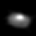

In [ ]:
#@markdown Visualize ROI images
%matplotlib notebook
roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

# Draw Selection

In [ ]:
#@markdown Prepare UMAP

n_pcs_toKeep_nn = 40
n_pcs_toKeep_swt = 10

comp_nn, scores_nn, SVs, EVR_nn = roicat.helpers.torch_pca(roinet.latents, device=colab_device, rank=n_pcs_toKeep_nn, zscore=False)
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)

umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
emb_umap = umap.fit_transform(features_norm)
# emb_nn = umap.fit_transform(scores_nn)

bool_good, dist_mat_pruned = get_spread_out_points(emb_umap, thresh_dist=0.25, n_iter=3)
idx_good = np.nonzero(bool_good)[0]

  0%|          | 0/2382 [00:00<?, ?it/s]<ipython-input-3-721ca2dd1157>:15: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(dist_mat_pruned[idx]) < thresh_dist:
100%|██████████| 2382/2382 [00:00<00:00, 46802.92it/s]


In [ ]:
#@markdown Load interactive plot so that you can draw selection and choose good ROIs.

#@markdown Use **LASSO** or **Box tool** to draw selection.

#@markdown Draw selection will save good ROIs' indices in a temporary file.
plot_size = 800, 800 #@param {type:"raw"}
#@markdown Plot Size in pixel. **Default: 800, 800**, _type: tuple_
size_images_overlay = None #@param {type: "raw"}
#@markdown Overlay Image Size in axis unit. **None** for autosizing. **Default: None**, _type: float_

# UMAP drawing plus ROI image
ims_subset = roinet.ROI_images_rs[idx_good]

layout, path_tempFile, fn_get_indices = roicat.visualization.select_region_scatterPlot(
                                          data = emb_umap,
                                          path = None,
                                          images_overlay = ims_subset,
                                          idx_images_overlay = idx_good,
                                          size_images_overlay = size_images_overlay,
                                          figsize = plot_size,
                                          )

Output hidden; open in https://colab.research.google.com to view.

Number of 'good' and 'bad' ROIs from each session:
['good: 1000 / bad: 1382']



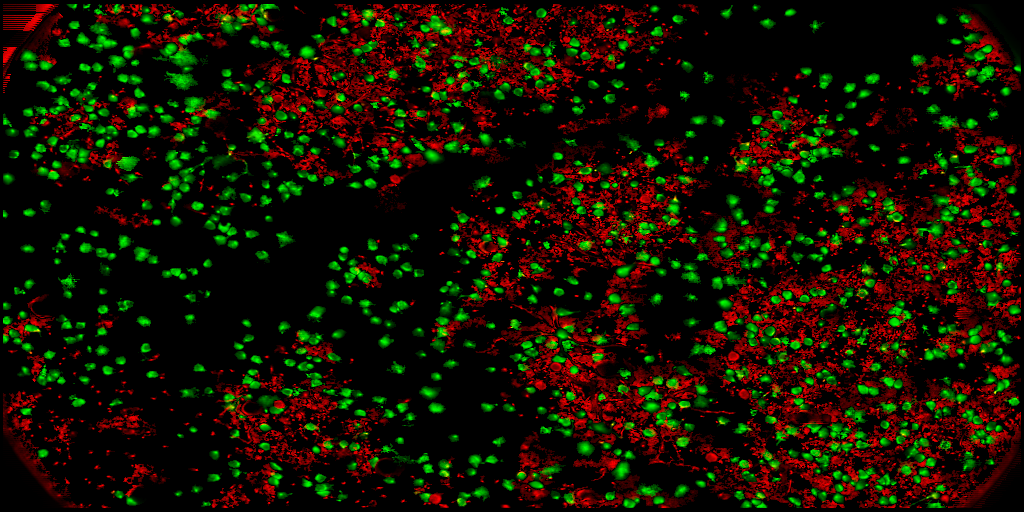

In [ ]:
#@markdown Visualize Classification results...
# Index good ROIs
selected_indices = fn_get_indices()
n_sessions = len(data.ROI_images)
idx_session_cat = np.concatenate([[ii]*data.ROI_images[ii].shape[0] for ii in range(n_sessions)])
bool_good_cat = roicat.helpers.idx2bool(selected_indices, length=len(idx_session_cat))
preds_good_sessions = [np.int64((bool_good_cat * (idx_session_cat==ii))[idx_session_cat==ii]) for ii in range(data.n_sessions)]

print(f"Number of 'good' and 'bad' ROIs from each session:")
print([f"good: {p.sum()} / bad: {(p!=1).sum()}" for p in preds_good_sessions])

# Visualize
%matplotlib inline
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=data.spatialFootprints,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    labels=preds_good_sessions,
    cmap=roicat.helpers.simple_cmap([[1,0,0],[0,1,0]]),
)

roicat.visualization.display_toggle_image_stack(FOVs_colored)

# Save Result

In [ ]:
#@markdown Save result in temporary Colab cloud...
save_filename = datetime.now().strftime("%Y%m%d-%H%M%S") + '_ROICaT.classification_drawn.results' + '.pkl'
path_save = Path.cwd() / save_filename
print(f'Classification result on Colab cloud: {path_save}')

classification_output = {
    'preds': preds_good_sessions,
    'spatialFootprints': data.spatialFootprints,
    'FOV_height': data.FOV_height,
    'FOV_width': data.FOV_width,
}

roicat.helpers.pickle_save(classification_output, path_save)

Classification results on Colab cloud: /content/20230612-144045_ROICaT.classification_drawn.results.pkl


In [ ]:
#@markdown This cell saves output file to your gdrive.
import shutil

if ('path_gdrive' not in locals()) and ('path_gdrive' not in globals()):
  from google.colab import drive
  path_gdrive = '/content/gdrive'
  drive.mount(path_gdrive, force_remount=True)

  copy_path = Path(path_gdrive) / 'MyDrive' / save_filename
  shutil.copyfile(path_save, copy_path)
  print(f'Classification Result on your gdrive: {copy_path}')

Classification Results on your gdrive: /content/gdrive/MyDrive/20230612-144045_ROICaT.classification_drawn.results.pkl


In [ ]:
#@markdown This cell downloads output file to your local computer.

#@markdown Please note that **this process could be pretty slow!**
from google.colab import files
files.download(path_save) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>